Installing (updating) the following libraries for your Sagemaker
instance.

In [ ]:
!pip install .. # installing d2l


# Estabilidade Numérica e Inicialização
:label:`sec_numerical_stability`


Até agora, todos os modelos que implementamos
exigiram que inicializássemos seus parâmetros
de acordo com alguma distribuição pré-especificada.
Até agora, considerávamos o esquema de inicialização garantido,
encobrindo os detalhes de como essas escolhas são feitas.
Você pode até ter ficado com a impressão de que essas escolhas
não são especialmente importantes.
Pelo contrário, a escolha do esquema de inicialização
desempenha um papel significativo na aprendizagem da rede neural,
e pode ser crucial para manter a estabilidade numérica.
Além disso, essas escolhas podem ser amarradas de maneiras interessantes
com a escolha da função de ativação não linear.
Qual função escolhemos e como inicializamos os parâmetros
pode determinar a rapidez com que nosso algoritmo de otimização converge.
Escolhas ruins aqui podem nos fazer encontrar
explosões ou desaparecimento de gradientes durante o treinamento.
Nesta seção, nos aprofundamos nesses tópicos com mais detalhes
e discutimos algumas heurísticas úteis
que você achará útil
ao longo de sua carreira em *deep learning*.

## Explosão e Desaparecimento  de Gradientes 

Considere uma rede profunda com $ L $ camadas,
entrada $ \ mathbf {x} $ e saída $\mathbf{o}$.
Com cada camada $l$ definida por uma transformação $f_l$
parametrizada por pesos $\mathbf{W}^{(l)}$,
cuja variável oculta é $\mathbf{h}^{(l)}$ (com $\mathbf{h}^{(0)} = \mathbf{x}$),
nossa rede pode ser expressa como:

$$\mathbf{h}^{(l)} = f_l (\mathbf{h}^{(l-1)}) \text{ e portanto } \mathbf{o} = f_L \circ \ldots \circ f_1(\mathbf{x}).$$

Se todas as variáveis ocultas e a entrada forem vetores,
podemos escrever o gradiente de $\mathbf{o}$ em relação a
qualquer conjunto de parâmetros $\mathbf{W}^{(l)}$ da seguinte forma:

$$\partial_{\mathbf{W}^{(l)}} \mathbf{o} = \underbrace{\partial_{\mathbf{h}^{(L-1)}} \mathbf{h}^{(L)}}_{ \mathbf{M}^{(L)} \stackrel{\mathrm{def}}{=}} \cdot \ldots \cdot \underbrace{\partial_{\mathbf{h}^{(l)}} \mathbf{h}^{(l+1)}}_{ \mathbf{M}^{(l+1)} \stackrel{\mathrm{def}}{=}} \underbrace{\partial_{\mathbf{W}^{(l)}} \mathbf{h}^{(l)}}_{ \mathbf{v}^{(l)} \stackrel{\mathrm{def}}{=}}.$$


Em outras palavras, este gradiente é
o produto das matrizes $L-l$
$\mathbf{M}^{(L)} \cdot \ldots \cdot \mathbf{M}^{(l+1)}$
e o vetor gradiente $\mathbf{v}^{(l)}$.
Assim, somos suscetíveis aos mesmos
problemas de *underflow* numérico que muitas vezes surgem
ao multiplicar muitas probabilidades.
Ao lidar com probabilidades, um truque comum é
mudar para o espaço de registro, ou seja, mudar
pressão da mantissa para o expoente
da representação numérica.
Infelizmente, nosso problema acima é mais sério:
inicialmente as matrizes $\mathbf{M}^{(l)}$ podem ter uma grande variedade de autovalores.
Eles podem ser pequenos ou grandes e
seu produto pode ser *muito grande* ou *muito pequeno*.

Os riscos apresentados por gradientes instáveis
vão além da representação numérica.
Gradientes de magnitude imprevisível
também ameaçam a estabilidade de nossos algoritmos de otimização.
Podemos estar enfrentando atualizações de parâmetros que são
(i) excessivamente grandes, destruindo nosso modelo
(o problema da *explosão do gradiente*);
ou (ii) excessivamente pequeno
(o problema do *desaparecimento do gradiente*),
tornando a aprendizagem impossível como parâmetros
dificilmente se move a cada atualização.


### (**Desaparecimento do Gradiente**)

Um culpado frequente que causa o problema do desaparecimento de gradiente 
é a escolha da função de ativação $\sigma$
que é anexada após as operações lineares de cada camada.
Historicamente, a função sigmóide
$1/(1 + \exp(-x))$ (introduzida em :numref:`sec_mlp`)
era popular porque se assemelha a uma função de limiar.
Como as primeiras redes neurais artificiais foram inspiradas
por redes neurais biológicas,
a ideia de neurônios que disparam *totalmente* ou *nem um pouco*
(como neurônios biológicos) parecia atraente.
Vamos dar uma olhada mais de perto no sigmóide
para ver por que isso pode causar desaparecimento de gradientes.


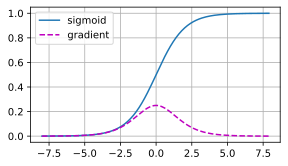

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

Como você pode ver, (**o gradiente do sigmóide desaparece
tanto quando suas entradas são grandes quanto quando são pequenas**).
Além disso, ao retropropagar através de muitas camadas,
a menos que estejamos na zona Cachinhos Dourados, onde
as entradas para muitos dos sigmóides são próximas de zero,
os gradientes do produto geral podem desaparecer.
Quando nossa rede possui muitas camadas,
a menos que tenhamos cuidado, o gradiente
provavelmente será cortado em alguma camada.
Na verdade, esse problema costumava atormentar o treinamento profundo da rede.
Consequentemente, ReLUs, que são mais estáveis
(mas menos neuralmente plausíveis),
surgiram como a escolha padrão para os profissionais.


### [**Explosão de Gradiente**]

O problema oposto, quando os gradientes explodem,
pode ser igualmente irritante.
Para ilustrar isso um pouco melhor,
desenhamos 100 matrizes aleatórias Gaussianas
e multiplicamos-nas com alguma matriz inicial.
Para a escala que escolhemos
(a escolha da variação $\sigma^2=1$),
o produto da matriz explode.
Quando isso acontece devido à inicialização
de uma rede profunda, não temos chance de obter
um otimizador de gradiente descendente capaz de convergir.


In [2]:
M = torch.normal(0, 1, size=(4,4))
print('a single matrix \n',M)
for i in range(100):
    M = torch.mm(M,torch.normal(0, 1, size=(4, 4)))

print('after multiplying 100 matrices\n', M)

a single matrix 
 tensor([[ 1.4391,  0.5853,  0.3140, -0.8884],
        [ 1.4385,  1.3793, -1.2473,  0.6873],
        [ 0.1406, -0.1450, -0.5697, -0.2563],
        [-0.8765, -0.1916,  0.1412,  0.3991]])
after multiplying 100 matrices
 tensor([[-1.5826e+23,  6.3882e+22, -2.6931e+23, -5.2050e+23],
        [-3.4426e+23,  1.3896e+23, -5.8582e+23, -1.1322e+24],
        [-2.7453e+22,  1.1081e+22, -4.6717e+22, -9.0290e+22],
        [ 1.1260e+23, -4.5449e+22,  1.9160e+23,  3.7031e+23]])


### Quebrando a Simetria


Outro problema no projeto de rede neural
é a simetria inerente à sua parametrização.
Suponha que temos um MLP simples
com uma camada oculta e duas unidades.
Neste caso, poderíamos permutar os pesos $\mathbf{W}^{(1)}$
da primeira camada e da mesma forma permutar
os pesos da camada de saída
para obter a mesma função.
Não há nada especial em diferenciar
a primeira unidade oculta vs. a segunda unidade oculta.
Em outras palavras, temos simetria de permutação
entre as unidades ocultas de cada camada.

Isso é mais do que apenas um incômodo teórico.
Considere o já mencionado MLP de uma camada oculta
com duas unidades ocultas.
Para ilustração,
suponha que a camada de saída transforme as duas unidades ocultas em apenas uma unidade de saída.
Imagine o que aconteceria se inicializássemos
todos os parâmetros da camada oculta
como $\mathbf{W}^{(1)} = c$ para alguma constante $c$.
Neste caso, durante a propagação direta
qualquer unidade oculta leva as mesmas entradas e parâmetros
a produzir a mesma ativação,
que é alimentada para a unidade de saída.
Durante a retropropagação,
diferenciar a unidade de saída com respeito aos parâmetros $\mathbf{W}^{(1)}$ dá um gradiente cujos elementos tomam o mesmo valor.
Assim, após a iteração baseada em gradiente (por exemplo, gradiente descendente estocástico de *minibatch*),
todos os elementos de $\mathbf{W}^{(1)}$ ainda têm o mesmo valor.
Essas iterações nunca iriam *quebrar a simetria* por conta própria
e podemos nunca ser capazes de perceber
o poder expressivo da rede.
A camada oculta se comportaria
como se tivesse apenas uma unidade.
Observe que, embora o gradiente descendente estocástico de *minibatch* não quebrasse essa simetria, a
regularização do *dropout* iria!


## Inicialização de Parâmetros

Uma forma de abordar --- ou pelo menos mitigar --- os
problemas levantados acima é através de inicialização cuidadosa.
Cuidado adicional durante a otimização
e a regularização adequada pode aumentar ainda mais a estabilidade.


### Inicialização Padrão

Nas seções anteriores, por exemplo, em :numref:`sec_linear_concise`,
nós usamos uma distribuição normal
para inicializar os valores de nossos pesos.
Se não especificarmos o método de inicialização, o *framework* irá
usar um método de inicialização aleatória padrão, que geralmente funciona bem na prática
para tamanhos moderados de problemas.






### Inicialização de Xavier
:label:`subsec_xavier`

Vejamos a distribuição da escala de
uma saída (por exemplo, uma variável oculta) $o_{i}$ para alguma camada totalmente conectada
*sem não linearidades*.
Com $n_\mathrm{in}$, entradas $x_j$
e seus pesos associados $w_{ij}$ para esta camada,
uma saída é dada por

$$o_{i} = \sum_{j=1}^{n_\mathrm{in}} w_{ij} x_j.$$

Os pesos $w_{ij}$ estão todos sorteados
independentemente da mesma distribuição.
Além disso, vamos supor que esta distribuição
tem média zero e variância $\sigma^2$.
Observe que isso não significa que a distribuição deve ser gaussiana,
apenas que a média e a variância precisam existir.
Por enquanto, vamos supor que as entradas para a camada $x_j$
também têm média zero e variância $\gamma^2$
e que elas são independentes de $w_{ij}$ e independentes uma da outra.
Nesse caso, podemos calcular a média e a variância de $o_i$ da seguinte forma:

$$
\begin{aligned}
    E[o_i] & = \sum_{j=1}^{n_\mathrm{in}} E[w_{ij} x_j] \\&= \sum_{j=1}^{n_\mathrm{in}} E[w_{ij}] E[x_j] \\&= 0, \\
    \mathrm{Var}[o_i] & = E[o_i^2] - (E[o_i])^2 \\
        & = \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij} x^2_j] - 0 \\
        & = \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij}] E[x^2_j] \\
        & = n_\mathrm{in} \sigma^2 \gamma^2.
\end{aligned}
$$

Uma maneira de manter a variância fixa
é definir $n_\mathrm{in} \sigma^2 = 1$.
Agora, considere a retropropagação.
Lá nós enfrentamos um problema semelhante,
embora com gradientes sendo propagados das camadas mais próximas da saída.
Usando o mesmo raciocínio da propagação direta,
vemos que a variância dos gradientes pode explodir
a menos que $n_\mathrm{out} \sigma^2 = 1$,
onde $n_\mathrm{out}$ é o número de saídas desta camada.
Isso nos deixa em um dilema:
não podemos satisfazer ambas as condições simultaneamente.
Em vez disso, simplesmente tentamos satisfazer:

$$
\begin{aligned}
\frac{1}{2} (n_\mathrm{in} + n_\mathrm{out}) \sigma^2 = 1 \text{ or equivalently }
\sigma = \sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}.
\end{aligned}
$$

Este é o raciocínio subjacente à agora padrão
e praticamente benéfica *inicialização de Xavier*,
em homenagem ao primeiro autor de seus criadores :cite:`Glorot.Bengio.2010`.
Normalmente, a inicialização de Xavier
amostra pesos de uma distribuição gaussiana
com média e variância zero
$\sigma^2 = \frac{2}{n_\mathrm{in} + n_\mathrm{out}}$.
Também podemos adaptar a intuição de Xavier para
escolher a variância ao amostrar os pesos
de uma distribuição uniforme.
Observe que a distribuição uniforme $U(-a, a)$ tem variância $\frac{a^2}{3}$.
Conectar $\frac{a^2}{3}$ em nossa condição em $\sigma^2$
produz a sugestão de inicializar de acordo com

$$U\left(-\sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}, \sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}\right).$$

Embora a suposição de inexistência de não linearidades
no raciocínio matemático acima
pode ser facilmente violada em redes neurais,
o método de inicialização de Xavier
acaba funcionando bem na prática.


### Além


O raciocínio acima mal arranha a superfície
de abordagens modernas para inicialização de parâmetros.
Uma estrutura de *deep learning* geralmente implementa mais de uma dúzia de heurísticas diferentes.
Além disso, a inicialização do parâmetro continua a ser
uma área quente de pesquisa fundamental em *deep learning*.
Entre elas estão heurísticas especializadas para
parâmetros vinculados (compartilhados), super-resolução,
modelos de sequência e outras situações.
Por exemplo,
Xiao et al. demonstraram a possibilidade de treinar
Redes neurais de 10.000 camadas sem truques arquitetônicos
usando um método de inicialização cuidadosamente projetado :cite:`Xiao.Bahri.Sohl-Dickstein.ea.2018`.

Se o assunto interessar a você, sugerimos
um mergulho profundo nas ofertas deste módulo,
lendo os artigos que propuseram e analisaram cada heurística,
e explorando as publicações mais recentes sobre o assunto.
Talvez você tropece ou até invente
uma ideia inteligente e contribuir com uma implementação para estruturas de *deep learning*.


## Resumo

* Desaparecimento e explosão de gradientes são problemas comuns em redes profundas. É necessário muito cuidado na inicialização dos parâmetros para garantir que gradientes e parâmetros permaneçam bem controlados.
* As heurísticas de inicialização são necessárias para garantir que os gradientes iniciais não sejam nem muito grandes nem muito pequenos.
* As funções de ativação ReLU atenuam o problema do desaparecimento de gradiente. Isso pode acelerar a convergência.
* A inicialização aleatória é a chave para garantir que a simetria seja quebrada antes da otimização.
* A inicialização de Xavier sugere que, para cada camada, a variação de qualquer saída não é afetada pelo número de entradas e a variação de qualquer gradiente não é afetada pelo número de saídas.

## Exercícios

1. Você pode projetar outros casos em que uma rede neural pode exibir simetria exigindo quebra, além da simetria de permutação nas camadas de um MLP?
1. Podemos inicializar todos os parâmetros de peso na regressão linear ou na regressão *softmax* para o mesmo valor?
1. Procure limites analíticos nos autovalores do produto de duas matrizes. O que isso diz a você sobre como garantir que os gradientes sejam bem condicionados?
1. Se sabemos que alguns termos divergem, podemos consertar isso após o fato? Veja o artigo sobre escalonamento de taxa adaptável em camadas para se inspirar :cite:`You.Gitman.Ginsburg.2017`.


[Discussions](https://discuss.d2l.ai/t/104)


<!--stackedit_data:
eyJoaXN0b3J5IjpbMTY3NjMxMjA4OCwzODg0MzA1MSwtMjAyMT
I4MDkyNSwxNDY2NTU4NDY5LC0xNDYzMzc5NzAyLC0xNzYyMDQ4
Mjc3LDE2MjAzMTIzODhdfQ==
-->
